# Introduction
This example shows how to do image classification from scratch, starting from JPEG image files on disk, without leveraging pre-trained weights or a pre-made Keras Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary classification dataset.

We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Load the data: the Cats vs Dogs dataset

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

!unzip -q kagglecatsanddogs_5340.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   165M      0  0:00:04  0:00:04 --:--:--  180M
 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


Now we have a PetImages folder which contain two subfolders, Cat and Dog. Each subfolder contains image files for each category.

In [3]:
!ls PetImages

Cat  Dog


### Filter out corrupted images
When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [4]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


### Generate a Dataset

In [5]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


### Visualize the data
Here are the first 9 images in the training dataset. As you can see, label 1 is "dog" and label 0 is "cat".

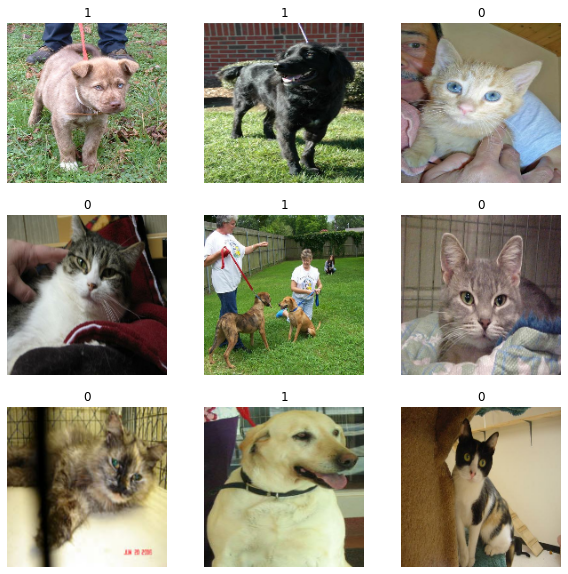

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Using image data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first image in the dataset:

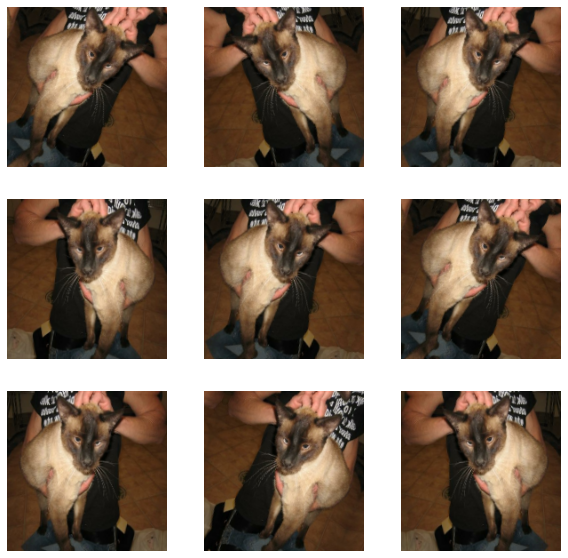

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")